# Goal
* gm on voxel intensities
* downsample and use voxel intensities for weight
* use top k values as weighted points (contains 95% of mass?)
* develop on mint chocolate chip

# Setup

In [2]:
import torch
import pandas as pd
import ot
import numpy as np
import matplotlib.pyplot as plt

# Import maps

In [3]:
fname = "/mnt/home/smbp/ceph/smbpchallenge/round2/set2/processed_submissions/submission_23.pt"

In [4]:
submission = torch.load(fname)

/tmp/ipykernel_984569/1569191833.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  submission = torch.load(fname)


In [5]:
volumes = submission["volumes"]
volumes.shape

torch.Size([80, 224, 224, 224])

<Axes: ylabel='Frequency'>

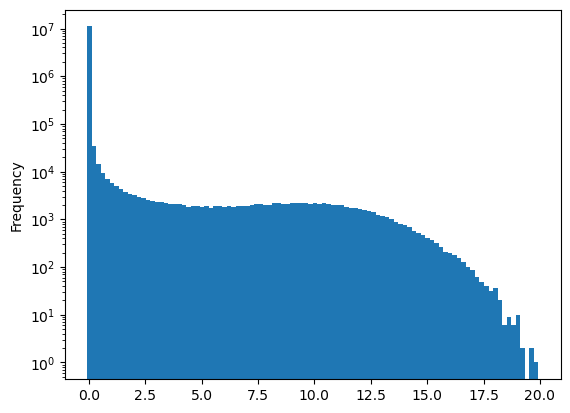

In [6]:
idx = 0
pd.Series(volumes[idx].numpy().flatten()).plot.hist(bins=100, logy=True)

<Axes: ylabel='Frequency'>

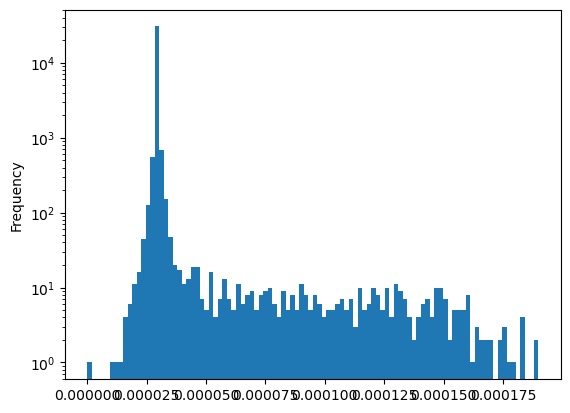

In [7]:
from cryo_challenge._preprocessing.fourier_utils import downsample_volume

n_downsample_pix = 32
volume = downsample_volume(volumes[idx], n_downsample_pix)
volume -= volume.min()
volume /= volume.sum()
pd.Series(volume.numpy().flatten()).plot.hist(logy=True, bins=100)
# volume = volumes[idx]
# n_downsampled = len(volume)

In [8]:
total_mass = volume.sum()
total_voxel_count = volume.numel()
n_pts = 1000
mass = np.zeros(n_pts)
voxel_count = np.zeros(n_pts)
thresholds = np.linspace(0, volume.max(), n_pts)
for idx_thresh, thresh in enumerate(thresholds):
    idx_above_thresh = volume > thresh
    voxel_count[idx_thresh] = number_of_voxels_above_thresh = idx_above_thresh.sum()
    mass[idx_thresh] = mass_above_thresh = volume[idx_above_thresh].sum() / total_mass
    print(
        "{:1.2f} | {:} | {:1.2f}".format(
            thresh, number_of_voxels_above_thresh, mass_above_thresh
        )
    )

0.00 | 32767 | 1.00
0.00 | 32767 | 1.00
0.00 | 32767 | 1.00
0.00 | 32767 | 1.00
0.00 | 32767 | 1.00
0.00 | 32767 | 1.00
0.00 | 32767 | 1.00
0.00 | 32767 | 1.00
0.00 | 32767 | 1.00
0.00 | 32767 | 1.00
0.00 | 32767 | 1.00
0.00 | 32767 | 1.00
0.00 | 32767 | 1.00
0.00 | 32767 | 1.00
0.00 | 32767 | 1.00
0.00 | 32767 | 1.00
0.00 | 32767 | 1.00
0.00 | 32767 | 1.00
0.00 | 32767 | 1.00
0.00 | 32767 | 1.00
0.00 | 32767 | 1.00
0.00 | 32767 | 1.00
0.00 | 32767 | 1.00
0.00 | 32767 | 1.00
0.00 | 32767 | 1.00
0.00 | 32767 | 1.00
0.00 | 32767 | 1.00
0.00 | 32767 | 1.00
0.00 | 32767 | 1.00
0.00 | 32767 | 1.00
0.00 | 32767 | 1.00
0.00 | 32767 | 1.00
0.00 | 32767 | 1.00
0.00 | 32767 | 1.00
0.00 | 32767 | 1.00
0.00 | 32767 | 1.00
0.00 | 32767 | 1.00
0.00 | 32767 | 1.00
0.00 | 32767 | 1.00
0.00 | 32767 | 1.00
0.00 | 32767 | 1.00
0.00 | 32767 | 1.00
0.00 | 32767 | 1.00
0.00 | 32767 | 1.00
0.00 | 32767 | 1.00
0.00 | 32767 | 1.00
0.00 | 32767 | 1.00
0.00 | 32767 | 1.00
0.00 | 32767 | 1.00
0.00 | 32767 | 1.00


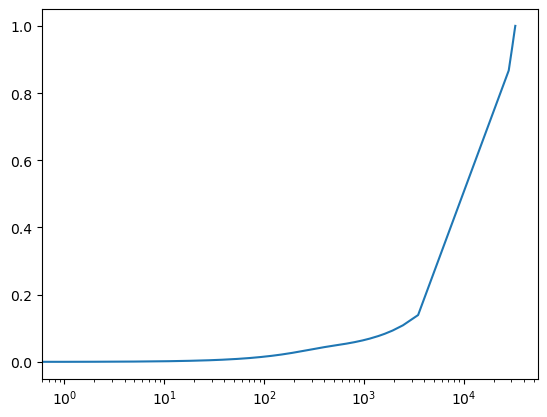

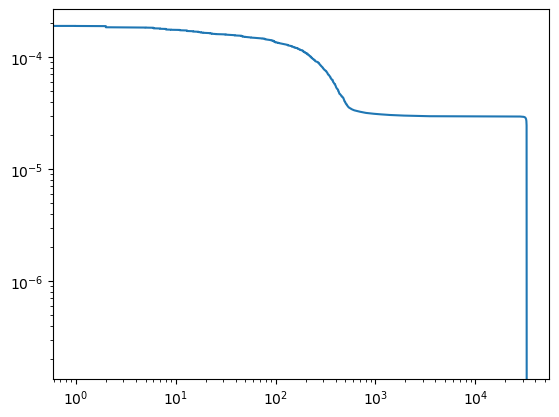

In [9]:
sr = pd.Series(mass, index=voxel_count)
sr.plot(logx=True)

plt.show()

sr = pd.Series(thresholds, index=voxel_count)
sr.plot(logx=True, logy=True)
plt.show()

The top 100k voxels have almost all of the mass. So a good place for a threshold.

Can also do some Fourier downsampling.

In [10]:
def return_top_k_voxel_idxs(volume, top_k):
    thresh = np.sort(volume.flatten())[-top_k - 1]
    idx_above_thresh = volume > thresh
    return idx_above_thresh


idx_above_thresh = return_top_k_voxel_idxs(volume, top_k=10**3)

In [11]:
# n_downsample_pix = 50
# n_pix = volumes.shape[1]
# start_idx = n_pix//2 - n_downsample_pix//2
# end_idx = n_pix//2 + n_downsample_pix//2
# volumes_downsampled = volumes[:, start_idx:end_idx, start_idx:end_idx, start_idx:end_idx]

In [12]:
def make_sparse_cost(idx_above_thresh):
    n_downsample_pix = len(idx_above_thresh)
    coordinates = torch.meshgrid(
        torch.arange(n_downsample_pix),
        torch.arange(n_downsample_pix),
        torch.arange(n_downsample_pix),
    )
    coordinates = torch.stack(coordinates, dim=-1)
    coordinates = coordinates.reshape(-1, 3).float()
    sparse_coordiantes = coordinates[idx_above_thresh.flatten()]
    pairwise_distances = torch.cdist(sparse_coordiantes, sparse_coordiantes)
    return pairwise_distances


pairwise_distances = make_sparse_cost(idx_above_thresh)

/mnt/home/gwoollard/software/mambaforge/envs/cryo_challenge/lib/python3.11/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [13]:
# pd.Series(volumes_downsampled[0].numpy().flatten()).hist(bins=100)

In [321]:
def normalize_mass_to_one(p):
    p = p - p.min()
    return p / p.sum()


top_k = 500
n_downsample_pix = 25

idx = 42  # 27
volume_1 = downsample_volume(volumes[idx], n_downsample_pix)
idx_above_thresh_1 = return_top_k_voxel_idxs(volume_1, top_k)
pairwise_distances_1 = make_sparse_cost(idx_above_thresh_1)

idx = 32
volume_2 = downsample_volume(volumes[idx], n_downsample_pix)
idx_above_thresh_2 = return_top_k_voxel_idxs(volume_2, top_k)
pairwise_distances_2 = make_sparse_cost(idx_above_thresh_2)

In [322]:
volume_1.shape

torch.Size([25, 25, 25])

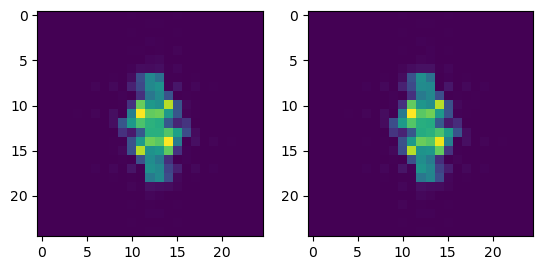

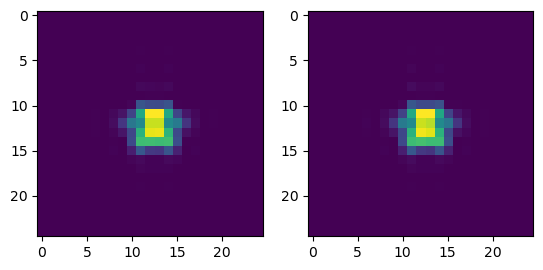

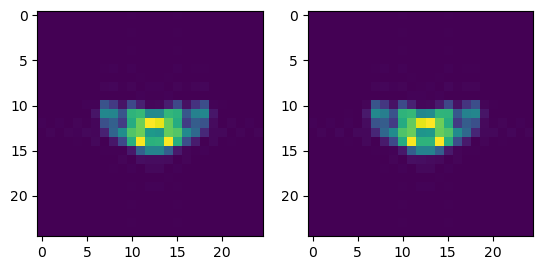

In [323]:
volume_1[~idx_above_thresh_1] = 0
volume_2[~idx_above_thresh_2] = 0

fig, axes = plt.subplots(1, 2)
axes[0].imshow(volume_1.sum(0))
axes[1].imshow(volume_2.sum(0))
plt.show()

fig, axes = plt.subplots(1, 2)
axes[0].imshow(volume_1.sum(1))
axes[1].imshow(volume_2.sum(1))
plt.show()

fig, axes = plt.subplots(1, 2)
axes[0].imshow(volume_1.sum(2))
axes[1].imshow(volume_2.sum(2))
plt.show()

In [347]:
p = normalize_mass_to_one(volume_1[idx_above_thresh_1].numpy().flatten()).astype(
    np.float64
)
q = normalize_mass_to_one(volume_2[idx_above_thresh_2].numpy().flatten()).astype(
    np.float64
)


gw_dist, log = ot.gromov.BAPG_gromov_wasserstein2(
    C1=(pairwise_distances_1.numpy() / pairwise_distances_1.numpy().max()).astype(
        np.float64
    ),
    C2=(pairwise_distances_2.numpy() / pairwise_distances_2.numpy().max()).astype(
        np.float64
    ),
    p=p,
    q=q,
    log=True,
    verbose=True,
    tol=1e-13,
    max_iter=1000,
    symmetric=True,
    loss_fun="square_loss",
    epsilon=0.001,
    # G0 = log['T'].T,
)

It.  |Err         
-------------------
    0|     nan|


/mnt/home/gwoollard/software/mambaforge/envs/cryo_challenge/lib/python3.11/site-packages/ot/backend.py:1150: RuntimeWarning: overflow encountered in exp
  return np.exp(a)
/mnt/home/gwoollard/software/mambaforge/envs/cryo_challenge/lib/python3.11/site-packages/ot/gromov/_bregman.py:501: RuntimeWarning: invalid value encountered in multiply
  T = T * nx.exp(- df(T) / epsilon)
/mnt/home/gwoollard/software/mambaforge/envs/cryo_challenge/lib/python3.11/site-packages/ot/gromov/_bregman.py:503: RuntimeWarning: invalid value encountered in multiply
  T = nx.reshape(row_scaling, (-1, 1)) * T


<Axes: >

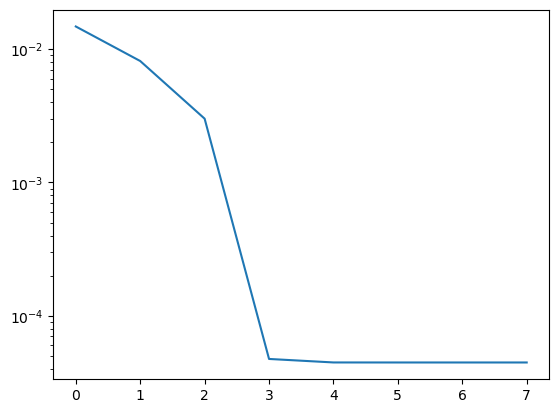

In [325]:
pd.Series(log["loss"]).plot(logy=True)

<Axes: >

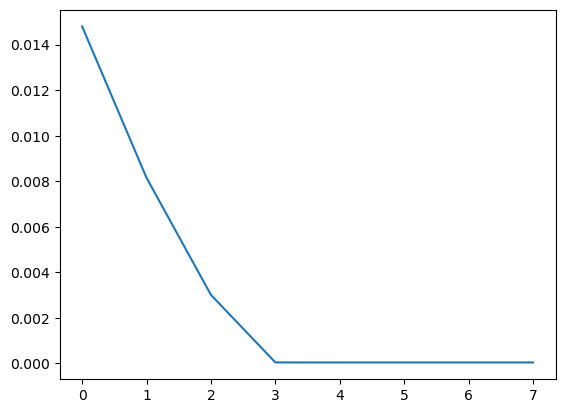

In [326]:
pd.Series(log["loss"]).plot()

In [332]:
volume_1_idxs = [32]  # range(0, 80, 5)
volume_2_idxs = range(0, 80, 1)
gw_distances = np.zeros((len(volume_1_idxs), len(volume_2_idxs)))
exponent = 0.8

for idx_1, vol_idx_1 in enumerate(volume_1_idxs):
    print(idx_1)
    volume_1 = downsample_volume(volumes[vol_idx_1], n_downsample_pix)
    idx_above_thresh_1 = return_top_k_voxel_idxs(volume_1, top_k)
    pairwise_distances_1 = make_sparse_cost(idx_above_thresh_1)

    for idx_2, vol_idx_2 in enumerate(volume_2_idxs):
        if idx_1 > idx_2:
            continue
        print(f"idx_2={idx_2}")
        volume_2 = downsample_volume(volumes[vol_idx_2], n_downsample_pix)
        idx_above_thresh_2 = return_top_k_voxel_idxs(volume_2, top_k)
        pairwise_distances_2 = make_sparse_cost(idx_above_thresh_2)

        p = normalize_mass_to_one(volume_1[idx_above_thresh_1].numpy().flatten())
        q = normalize_mass_to_one(volume_2[idx_above_thresh_2].numpy().flatten())
        C1 = (
            pairwise_distances_1.numpy() / pairwise_distances_1.numpy().max()
        ) ** exponent
        C2 = (
            pairwise_distances_2.numpy() / pairwise_distances_2.numpy().max()
        ) ** exponent

        gw_dist, log = ot.gromov_wasserstein2(
            C1=C1.astype(np.float64),
            C2=C2.astype(np.float64),
            p=p.astype(np.float64),
            q=q.astype(np.float64),
            log=True,
            verbose=False,
            max_iter=10000,
            tol_abs=1e-11,
            # G0=
        )
        # gw_distances[idx_1, idx_2] = gw_distances[idx_2, idx_1] = gw_dist.item()
        gw_distances[idx_1, idx_2] = gw_dist.item()

0
idx_2=0
idx_2=1
idx_2=2
idx_2=3
idx_2=4
idx_2=5
idx_2=6
idx_2=7
idx_2=8
idx_2=9
idx_2=10
idx_2=11
idx_2=12
idx_2=13
idx_2=14
idx_2=15
idx_2=16
idx_2=17
idx_2=18
idx_2=19
idx_2=20
idx_2=21
idx_2=22
idx_2=23
idx_2=24
idx_2=25
idx_2=26
idx_2=27
idx_2=28
idx_2=29
idx_2=30
idx_2=31
idx_2=32
idx_2=33
idx_2=34
idx_2=35
idx_2=36
idx_2=37
idx_2=38
idx_2=39
idx_2=40
idx_2=41
idx_2=42
idx_2=43
idx_2=44
idx_2=45
idx_2=46
idx_2=47
idx_2=48
idx_2=49
idx_2=50
idx_2=51
idx_2=52
idx_2=53
idx_2=54
idx_2=55
idx_2=56
idx_2=57
idx_2=58
idx_2=59
idx_2=60
idx_2=61
idx_2=62
idx_2=63
idx_2=64
idx_2=65
idx_2=66
idx_2=67
idx_2=68
idx_2=69
idx_2=70
idx_2=71
idx_2=72
idx_2=73
idx_2=74
idx_2=75
idx_2=76
idx_2=77
idx_2=78
idx_2=79


np.int64(79)

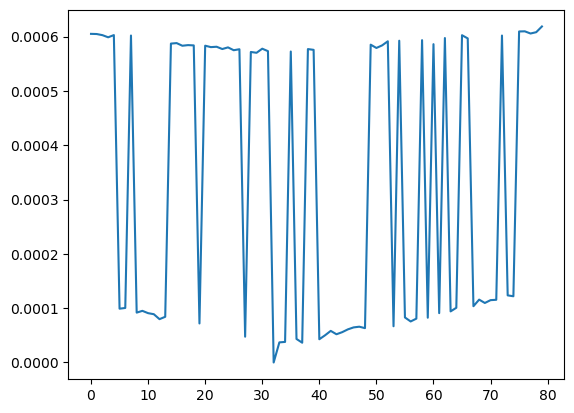

In [333]:
max_idx = gw_distances[0].argmax()
pd.Series(gw_distances[0]).plot()
max_idx

<Axes: ylabel='Frequency'>

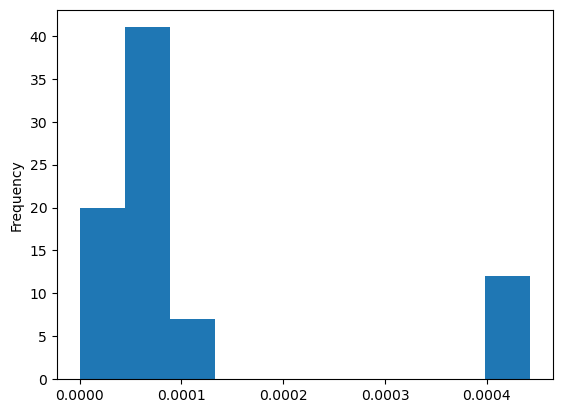

In [329]:
pd.Series(gw_distances[0]).plot.hist()

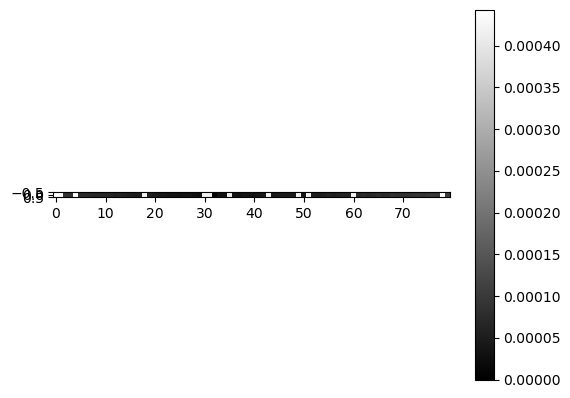

In [330]:
plt.imshow(gw_distances, cmap="gray")
plt.colorbar()

# dask

In [119]:
from dask import delayed, compute
from dask.distributed import Client
from dask.diagnostics import ProgressBar

# # Initialize a Dask client for parallel computation
client = Client(local_directory="/tmp")

/mnt/home/gwoollard/software/mambaforge/envs/cryo_challenge/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37445 instead
  warnings.warn(


In [ ]:
top_k = 3000
n_downsample_pix = 64


def prepare_volume_and_distance(volume, top_k=top_k, n_downsample_pix=n_downsample_pix):
    volume = downsample_volume(volume, n_downsample_pix)
    idx_above_thresh = return_top_k_voxel_idxs(volume, top_k)
    volume = normalize_mass_to_one(volume[idx_above_thresh].numpy().flatten())
    pairwise_distances = make_sparse_cost(idx_above_thresh)
    pairwise_distances = pairwise_distances.numpy() / pairwise_distances.numpy().max()
    return volume, pairwise_distances

In [ ]:
def gw_distance_wrapper(volumes, i, j, **kwargs):
    volume_i, pairwise_distances_i = prepare_volume_and_distance(volumes[i])
    volume_j, pairwise_distances_j = prepare_volume_and_distance(volumes[j])
    gw_dist, results_dict = gw_distance(
        volume_i, volume_j, pairwise_distances_i, pairwise_distances_j, **kwargs
    )

    ij_results = {
        "i": i,
        "j": j,
        "results_dict": results_dict,
    }
    return gw_dist, ij_results


gw_distance_function_d = {
    "entropic_gromov_wasserstein2": ot.gromov.entropic_gromov_wasserstein2,
    "gromov_wasserstein2": ot.gromov.gromov_wasserstein2,
}
gw_distance_function = "gromov_wasserstein2"


def gw_distance(
    volume_i, volume_j, pairwise_distances_i, pairwise_distances_j, **kwargs
):
    gw_dist, results_dict = gw_distance_function_d[gw_distance_function](
        pairwise_distances_i,
        pairwise_distances_j,
        volume_i,
        volume_j,
        log=True,
        **kwargs,
    )
    return gw_dist, results_dict

In [122]:
# epsilon = 10
tol = 1e-11
# solver='PGA'
max_iter = 10000
symmetric = True
verbose = False
loss_fun = "square_loss"


def get_distance_matrix_dask(volumes, distance_function):
    n_vols = len(volumes)
    distance_matrix = np.zeros((n_vols, n_vols))

    # Create a list to hold the delayed computations
    tasks = []

    for i in range(n_vols):
        for j in range(i + 1, n_vols):
            # Use dask.delayed to delay the computation
            compute_task = delayed(distance_function)(
                volumes,
                i,
                j,
                loss_fun=loss_fun,
                tol=tol,
                symmetric=symmetric,
                max_iter=max_iter,
                verbose=verbose,
            )
            tasks.append((i, j, compute_task))

    # Compute all tasks in parallel using the Dask client
    with ProgressBar():
        idx_of_return = 0
        idx_of_compute_task = 2
        results = compute(
            *[task[idx_of_compute_task][idx_of_return] for task in tasks],
            scheduler="single-threaded",
        )

    # Fill in the distance matrix with the results
    for (i, j, _), result in zip(tasks, results):
        distance_matrix[i, j] = distance_matrix[j, i] = result

    return distance_matrix


n_interval = 5
get_distance_matrix_dask_gw = get_distance_matrix_dask(
    volumes[::n_interval], distance_function=gw_distance_wrapper
)

[                                        ] | 0% Completed | 1.43 ms

[                                        ] | 0% Completed | 3.65 s ms

/mnt/home/gwoollard/software/mambaforge/envs/cryo_challenge/lib/python3.11/site-packages/ot/lp/__init__.py:361: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


[########################################] | 100% Completed | 41m 42s


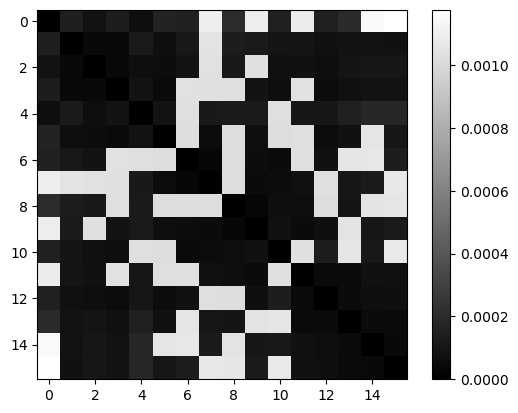

In [124]:
plt.imshow(get_distance_matrix_dask_gw, cmap="gray")
plt.colorbar()

# inspect results

In [19]:
fname = "/mnt/home/gwoollard/ceph/repos/Cryo-EM-Heterogeneity-Challenge-1/src/cryo_challenge/_map_to_map/gromov_wasserstein/gw_weighted_voxel_topk3000_ds20_23.npy"
get_distance_matrix_dask_gw = np.load(fname)

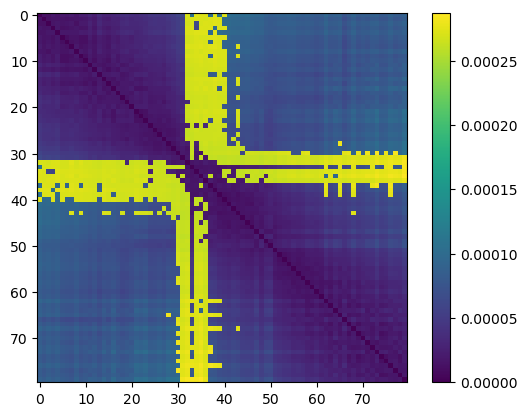

In [20]:
plt.imshow(get_distance_matrix_dask_gw)
plt.colorbar()

<Axes: ylabel='Frequency'>

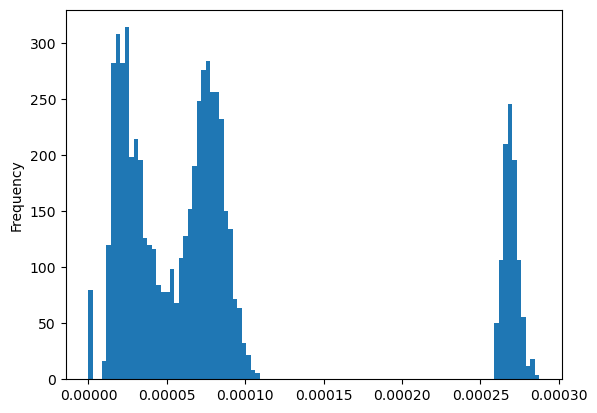

In [21]:
pd.Series(get_distance_matrix_dask_gw.flatten()).plot.hist(bins=100)

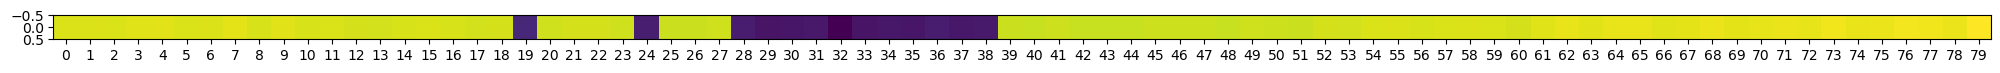

In [45]:
fig, ax = plt.subplots(1, figsize=(25, 2))

ax.imshow(get_distance_matrix_dask_gw[:, 32:33].T)
ax.set_xticks(range(0, len(get_distance_matrix_dask_gw), 1))
# get_distance_matrix_dask_gw[27,32]

<Axes: ylabel='Frequency'>

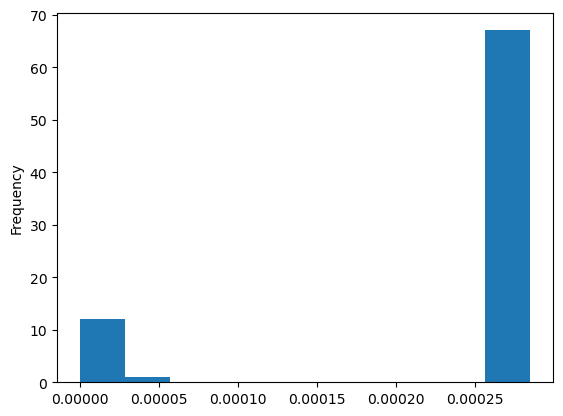

In [51]:
pd.Series(get_distance_matrix_dask_gw[:, 32:33].flatten()).plot.hist()

In [33]:
np.allclose(get_distance_matrix_dask_gw, get_distance_matrix_dask_gw.T)

True